# GIA - Práctica 2
## Segmentación

El objetivo de esta práctica es el desarrollo de una metodología para la segmentación automática de las regiones de fluido patológico en imágenes OCT.


In [1]:
# Connect to drive

from google.colab import drive
import os

drive.mount('/content/gdrive')

route = '/content/gdrive/MyDrive/GIA/VCA/P2/'

print('\nChange the directory to project route')
%cd $route

Mounted at /content/gdrive

Change the directory to project route
/content/gdrive/MyDrive/GIA/VCA/P2


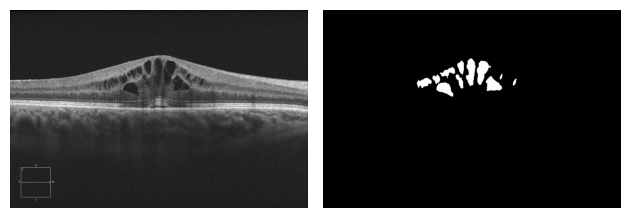

In [2]:
import matplotlib.pyplot as plt

# Aux function that shows an image and its corresponding mask in the same figure
def show(image, mask, title=None):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image, cmap="gray")
    ax[0].axis('off')
    if title is not None:
        fig.suptitle(title)
    ax[1].imshow(mask, cmap="gray")
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

im = plt.imread(f"{route}OCT-dataset/images/sample_01.jpg")
mask = plt.imread(f"{route}OCT-dataset/masks/sample_01.jpg")
show(im, mask)

**Sugerencia**: Para el cálculo de métricas de rendimiento se puede utilizar la siguiente función auxiliar que permite obtener la máscara de segmentación a partir de las salidas de la red. La salida de la red es un valor positivo en coma flotante. La función sigmoidea restringe el dominio de salida entre 0 y 1. Como la máscara de salida es binaria, usamos un umbral para establecer los valores de la máscara de salida en 0 ó 1. Ten en cuenta que tal vez tengas que ajustar el umbral por defecto.

In [3]:
# Aux function to get binary segmentation mask
import torch
def get_segmentation_masks(outputs, threshold=0.5):
    probs = torch.sigmoid(outputs)
    masks = (probs > threshold) * 1.0
    return masks

# Aux function to show results
def show_result(orig, gt, prediction, title=None):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    ax = axes.ravel()

    images = [orig, gt, prediction, orig*prediction]
    titles = ['Orig', 'Gt', 'Result', 'Overlap']
    for i, (im, tit) in enumerate(zip(images, titles)):
        ax[i].imshow(im, cmap='gray')
        ax[i].set_title(tit)
        ax[i].axis('off')
    plt.show()

## UNet
UNet es una red convolucional diseñada para la segmentación de imágenes biomédicas. Sus tasas de éxito son altas incluso con pocas imágenes en el conjunto de entrenamiento.
En esta práctica abordaremos la tarea de segmentación usando una UNet. Los pasos generales a seguir son los siguientes:
1. Definir la arquitectura de red
2. Creación de dataset
   - Generar conjuntos de entrenamiento, validación y test
3. Entrenar la red
4. Seleccionar modelo en base a conjunto de validación
5. Test del modelo seleccionado

### Definición de la arquitectura de red

In [4]:
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )


class UNet(nn.Module):

    def __init__(self, input_channels, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(input_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

### Creación de Dataset

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import torchvision.transforms as transforms
import glob
import os
import numpy as np
import random
import cv2

class OCTDataset(Dataset):

    def __init__(self, image_path, mask_path, rsize = (416,624), transform = None):
        super().__init__()
        # Load all the filenames with extension tif from the image_path directory
        self.img_files = glob.glob(os.path.join(image_path,'*.jpg'))

        self.mask_files = []

        # We asume that each image has the same filename as its corresponding mask
        # but it is stored in another directory (mask_path)
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(mask_path, os.path.basename(img_path)))

        self.rsize = rsize  # Size to use in default Resize transform
        self.transform = transform

    # Returns both the image and the mask
    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = plt.imread(img_path)
        mask = plt.imread(mask_path)
        if len(mask.shape) > 2:
            mask = mask[:,:,0]
        if len(image.shape) > 2:
            image = image[:,:,0]
        _, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY) # Make sure that mask is binary
        # Apply the defined transformations to both image and mask
        if self.transform is not None:
            seed = np.random.randint(2147483647) # make a seed with numpy generator
            random.seed(seed) # apply this seed to image transforms
            torch.manual_seed(seed)
            image = self.transform(image)
            random.seed(seed) # apply the same seed to mask transforms
            torch.manual_seed(seed)
            mask = self.transform(mask)
        else:
            t = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(self.rsize, interpolation= InterpolationMode.NEAREST),
                transforms.ToTensor()])

            image = t(image)
            mask = t(mask)

        return image, mask

    def __len__(self):
        return len(self.img_files)

Dataset len: 50


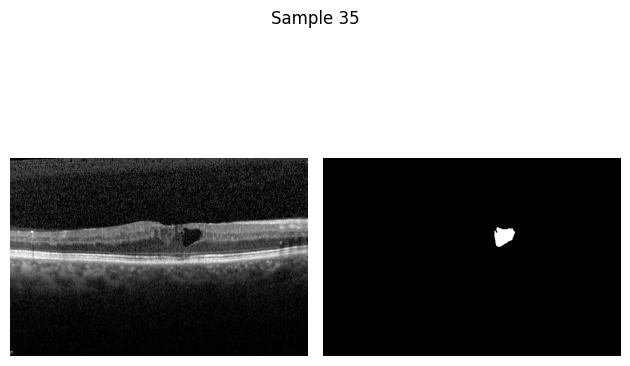

In [6]:
# Load some samples
simple_dataset = OCTDataset(f"{route}/OCT-dataset/images", f"{route}/OCT-dataset/masks")
print("Dataset len:", len(simple_dataset))
nsamples = 1
for _ in range(nsamples):
    idx = np.random.randint(0, len(simple_dataset))
    im, mask = simple_dataset[idx]
    show(im.squeeze(), mask.squeeze(), title=f"Sample {idx}")

### Partición del dataset en entrenamiento/validación

In [7]:
import glob
import os

image_path = "OCT-dataset/images"
mask_path = "OCT-dataset/masks"

all_images = glob.glob(os.path.join(image_path, '*.jpg'))

val_size = 5
test_size = 5

test_imgs = all_images[:test_size]
val_imgs = all_images[test_size:test_size+val_size]
train_imgs = all_images[test_size+val_size:]

print(f"Número de imágenes de entrenamiento: {len(train_imgs)}")
print(f"Número de imágenes de validación: {len(val_imgs)}")
print(f"Número de imágenes de test: {len(test_imgs)}")

Número de imágenes de entrenamiento: 40
Número de imágenes de validación: 5
Número de imágenes de test: 5


### Creación de datasets

In [8]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

# Transformación base para imágenes y máscaras (solo resize y tensorización)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((416, 624), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Dataset modificado para usar solo las imágenes de cada split
class OCTSubsetDataset(OCTDataset):
    def __init__(self, img_list, image_path, mask_path, transform=None):
        self.img_files = img_list
        self.mask_files = [os.path.join(mask_path, os.path.basename(p)) for p in img_list]
        self.rsize = (416, 624)
        self.transform = transform

train_dataset = OCTSubsetDataset(train_imgs, image_path, mask_path, transform=transform)
val_dataset = OCTSubsetDataset(val_imgs, image_path, mask_path, transform=transform)
test_dataset = OCTSubsetDataset(test_imgs, image_path, mask_path, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Entrenamiento del *baseline*

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [10]:
baseline = UNet(input_channels=1, n_class=1)

pos_weight = torch.tensor([40.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(baseline.parameters(), lr=1e-4)

In [11]:
def train_model(model, optimizer, loss_fn, train_loader, val_loader, scheduler=None, num_epochs=50, model_path="model.pth"):
    model.to(device)
    best_val_loss = float('inf')

    train_losses = list()
    val_losses = list()

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluación en validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, masks)

                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        if scheduler is not None:
            scheduler.step(val_loss)

        epoch_time = round(time.time() - start_time, 2)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time}")

        # Guardar el mejor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print("  ↳ Modelo guardado (el mejor hasta ahora)")

    # Mostramos la evolución del loss
    ticks = np.arange(1, num_epochs+1, 1)
    plt.plot(ticks, train_losses, label="train")
    plt.plot(ticks, val_losses, label="val")
    plt.legend(loc="lower left")
    plt.title("Loss during training and validation")
    # plt.xticks(ticks)
    plt.show()

    return model

Epoch [1/75] | Train Loss: 1.1234 | Val Loss: 1.0720 | Time: 43.28
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [2/75] | Train Loss: 1.1189 | Val Loss: 1.0657 | Time: 8.96
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [3/75] | Train Loss: 1.1120 | Val Loss: 1.0466 | Time: 10.01
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [4/75] | Train Loss: 1.0994 | Val Loss: 1.0301 | Time: 9.19
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [5/75] | Train Loss: 1.0940 | Val Loss: 1.0263 | Time: 9.11
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [6/75] | Train Loss: 1.0816 | Val Loss: 1.0014 | Time: 9.25
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [7/75] | Train Loss: 1.0541 | Val Loss: 0.9440 | Time: 9.28
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [8/75] | Train Loss: 0.9934 | Val Loss: 0.8650 | Time: 9.36
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [9/75] | Train Loss: 0.9989 | Val Loss: 0.8833 | Time: 9.53
Epoch [10/75] | Train Loss: 1.0183 | Val Loss: 0.9519 | Time

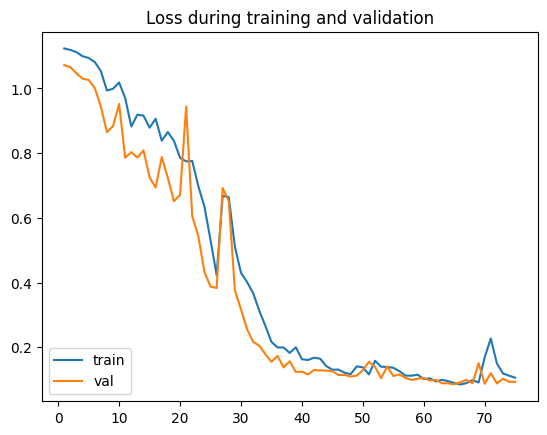

In [12]:
epochs = 75
baseline_path = "baseline_model.pth"

baseline = train_model(model=baseline,
                        optimizer=optimizer,
                        loss_fn=criterion,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        num_epochs=epochs,
                        model_path=baseline_path
                        )

### Evaluación

In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, jaccard_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def get_binary_mask(output, threshold=0.5):
    return (torch.sigmoid(output) > threshold).float()

def evaluate_thresholds(model, model_path, test_loader, thresholds):
    # Load best model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    results = np.zeros((len(thresholds), 6))

    # Loop for metrics at various thresholds
    for i, thresh in enumerate(thresholds):
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for images, masks in test_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                preds = get_binary_mask(outputs, threshold=thresh)

                # Flatten to compute metrics
                all_preds.extend(preds.cpu().numpy().reshape(preds.size(0), -1))
                all_targets.extend(masks.cpu().numpy().reshape(masks.size(0), -1))

        all_preds = np.vstack(all_preds)
        all_targets = np.vstack(all_targets)

        # Compute per-pixel metrics
        iou = jaccard_score(all_targets.flatten(), all_preds.flatten())
        acc = accuracy_score(all_targets.flatten(), all_preds.flatten())
        prec = precision_score(all_targets.flatten(), all_preds.flatten(), zero_division=0.0)
        rec = recall_score(all_targets.flatten(), all_preds.flatten())
        p_plus_r = prec + rec
        f1 = 0.0 if p_plus_r == 0.0 else ((prec * rec) / p_plus_r)

        results[i] = [thresh, iou, acc, prec, rec, f1]

    # Compute all probabilities and true labels for Precision-Recall curve
    all_probabilities = []
    all_true = []
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            all_probabilities.extend(probs.cpu().numpy().reshape(-1))
            all_true.extend(masks.cpu().numpy().reshape(-1))

    # Compute Precision-Recall curve and average precision score
    precision, recall, pr_thresholds = precision_recall_curve(all_true, all_probabilities)
    ap = average_precision_score(all_true, all_probabilities)

    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {ap:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()

    metrics_df = pd.DataFrame(results, columns=["Threshold", "IoU", "Accuracy", "Precision", "Recall", "F1-Score"])
    pd.set_option("display.precision", 4)
    display(metrics_df)

    return results

gap = 0.05
thresholds = np.arange(gap, 1, gap)

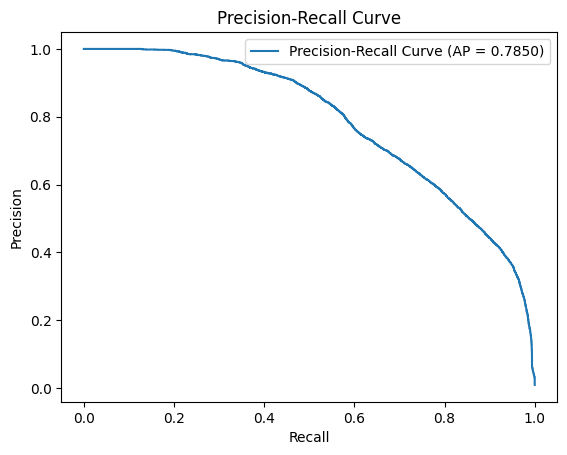

,Threshold,IoU,Accuracy,Precision,Recall,F1-Score
0,0.05,0.1349,0.9435,0.1350,0.9928,0.1188
1,0.10,0.1805,0.9602,0.1809,0.9878,0.1529
2,0.15,0.2159,0.9683,0.2166,0.9840,0.1775
3,0.20,0.2434,0.9730,0.2447,0.9794,0.1958
4,0.25,0.2664,0.9762,0.2682,0.9752,0.2104
5,0.30,0.2872,0.9786,0.2897,0.9707,0.2231
6,0.35,0.3074,0.9807,0.3108,0.9662,0.2351
7,0.40,0.3245,0.9822,0.3288,0.9612,0.2450
8,0.45,0.3391,0.9835,0.3446,0.9555,0.2533
9,0.50,0.3547,0.9846,0.3613,0.9507,0.2618


In [14]:
baseline_results = evaluate_thresholds(baseline, model_path=baseline_path, test_loader=test_loader, thresholds=thresholds)

In [15]:
def show_threshold_results(results, thresholds):
    iou_results  = results[:, 1]
    acc_results  = results[:, 2]
    prec_results = results[:, 3]
    rec_results  = results[:, 4]
    f1_results   = results[:, 5]

    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, iou_results, label="IoU")
    plt.plot(thresholds, acc_results, label="Accuracy")
    plt.plot(thresholds, prec_results, label="Precision")
    plt.plot(thresholds, rec_results, label="Recall")
    plt.plot(thresholds, f1_results, label="F1-Score")
    plt.legend(loc="center left")
    plt.title("Métricas con diferentes umbrales")
    plt.xticks(thresholds)
    plt.ylabel("Valor métrica")
    plt.xlabel("Umbral")
    plt.show()

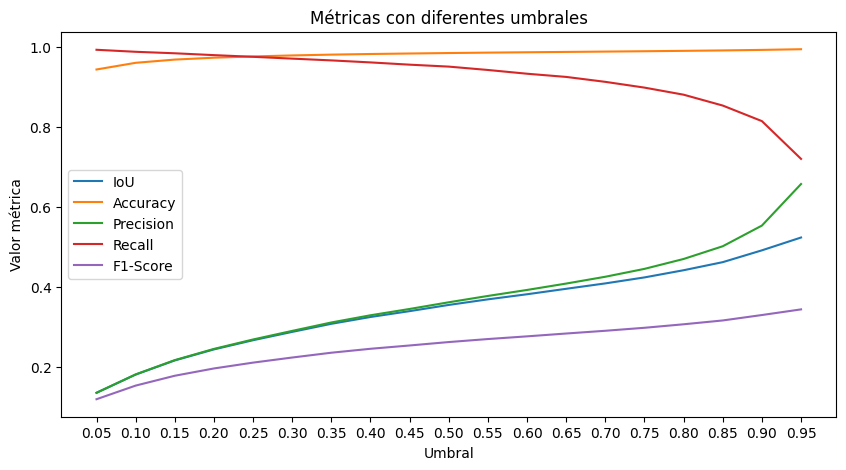

In [16]:
show_threshold_results(baseline_results, thresholds=thresholds)

In [17]:
def test_model(model, results, test_loader, threshold=0.5):
    row = results[np.isclose(results[:, 0], threshold)][0].tolist()

    # Printeamos las métricas
    print(f"IoU: {row[1]:.4f}")
    print(f"Accuracy: {row[2]:.4f}")
    print(f"Precision: {row[3]:.4f}")
    print(f"Recall: {row[4]:.4f}")
    print(f"F1 score: {row[5]:.4f}")

    # Mostrar ejemplos del conjunto de validación
    num_samples = 5
    model.eval()

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = get_binary_mask(outputs, threshold=threshold).cpu()

            for j in range(min(num_samples, images.size(0))):
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                ax[0].imshow(images[j].cpu().squeeze(), cmap="gray")
                ax[0].set_title("Imagen original")
                ax[1].imshow(masks[j].cpu().squeeze(), cmap="gray")
                ax[1].set_title("Máscara real")
                ax[2].imshow(preds[j].squeeze(), cmap="gray")
                ax[2].set_title("Predicción")
                for a in ax:
                    a.axis('off')
                plt.show()

            break  # solo una tanda de imágenes


IoU: 0.5233
Accuracy: 0.9942
Precision: 0.6571
Recall: 0.7199
F1 score: 0.3435


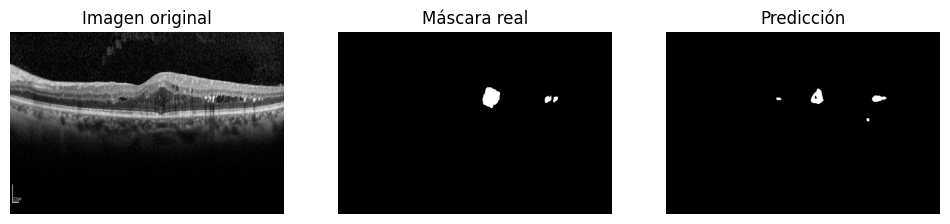

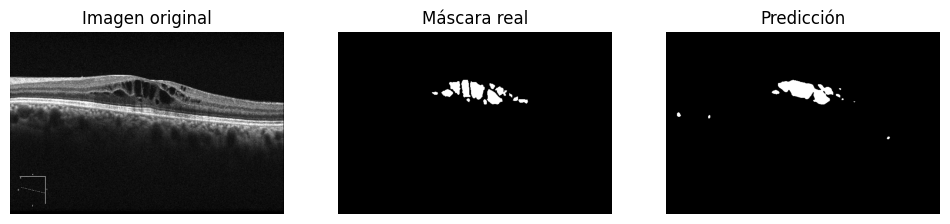

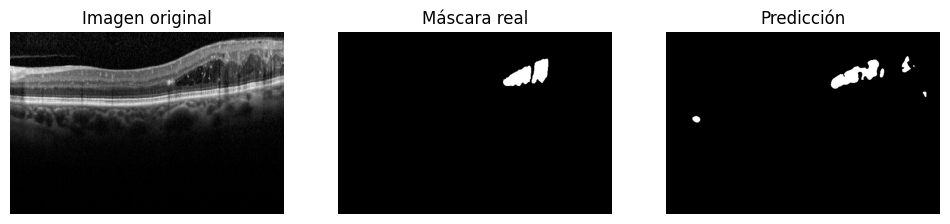

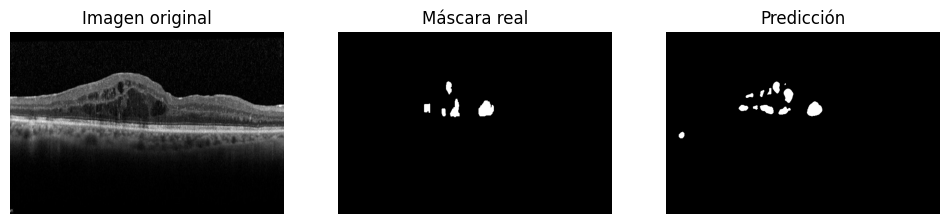

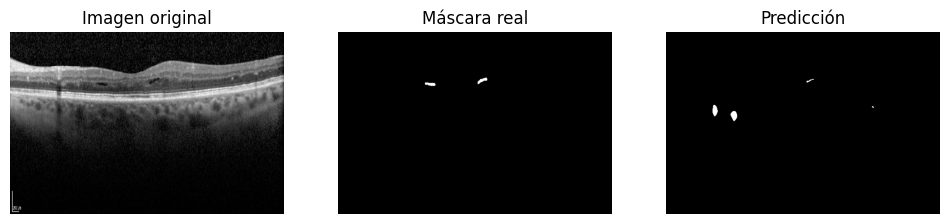

In [18]:
thresh = 0.95

test_model(results=baseline_results, model=baseline, threshold=thresh, test_loader=test_loader)

## Con *Data Augmentation*

In [19]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

# Transformación con data augmentation (solo para entrenamiento)
augmentation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((416, 624), interpolation=InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(contrast=.1),
    # transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)), # pequeños desplazamientos
    transforms.ToTensor()
])

train_dataset_aug = OCTSubsetDataset(train_imgs, image_path, mask_path, transform=augmentation_transform)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=8, shuffle=True)

#### Entrenamiento

In [20]:
aug = UNet(input_channels=1, n_class=1)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(aug.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=7)

Epoch [1/90] | Train Loss: 1.1431 | Val Loss: 1.1053 | Time: 9.71
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [2/90] | Train Loss: 1.1348 | Val Loss: 1.0960 | Time: 9.83
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [3/90] | Train Loss: 1.1218 | Val Loss: 1.0466 | Time: 9.79
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [4/90] | Train Loss: 1.1100 | Val Loss: 1.0512 | Time: 10.73
Epoch [5/90] | Train Loss: 1.0945 | Val Loss: 1.0547 | Time: 9.56
Epoch [6/90] | Train Loss: 1.0831 | Val Loss: 1.0319 | Time: 9.58
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [7/90] | Train Loss: 1.0773 | Val Loss: 1.0219 | Time: 9.64
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [8/90] | Train Loss: 1.0824 | Val Loss: 1.0340 | Time: 10.62
Epoch [9/90] | Train Loss: 1.0599 | Val Loss: 0.9908 | Time: 9.6
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [10/90] | Train Loss: 1.0275 | Val Loss: 0.9587 | Time: 9.73
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [11/90] | Train Loss: 0.9886 | 

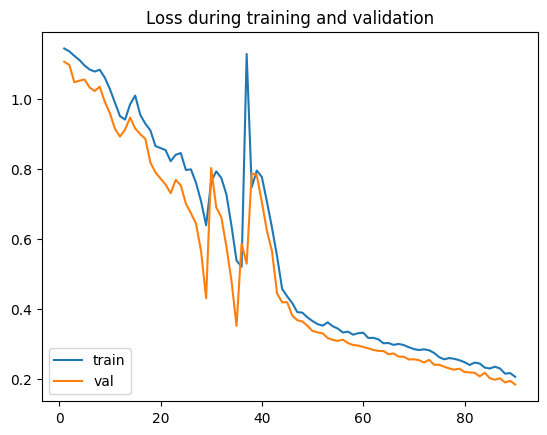

In [ ]:
epochs = 100
aug_path = "aug_model.pth"

aug = train_model(model=aug,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    loss_fn=criterion,
                    train_loader=train_loader_aug,
                    val_loader=val_loader,
                    num_epochs=epochs,
                    model_path=aug_path
                    )

#### Evaluación

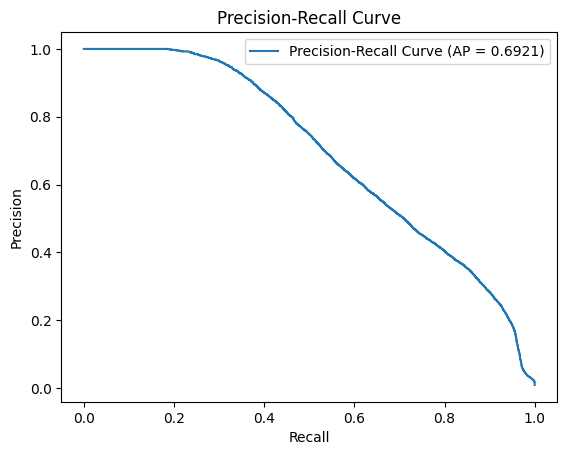

,Threshold,IoU,Accuracy,Precision,Recall,F1-Score
0,0.05,0.0256,0.6639,0.0256,0.9947,0.0249
1,0.10,0.0319,0.7338,0.0319,0.9888,0.0309
2,0.15,0.0390,0.7852,0.0390,0.9824,0.0375
3,0.20,0.0526,0.8441,0.0527,0.9747,0.0500
4,0.25,0.0856,0.9082,0.0858,0.9678,0.0788
5,0.30,0.1322,0.9440,0.1329,0.9608,0.1168
6,0.35,0.1739,0.9598,0.1754,0.9529,0.1481
7,0.40,0.1989,0.9663,0.2013,0.9432,0.1659
8,0.45,0.2228,0.9711,0.2264,0.9324,0.1822
9,0.50,0.2430,0.9745,0.2481,0.9220,0.1955


In [22]:
aug_results = evaluate_thresholds(aug, model_path=aug_path, thresholds=thresholds, test_loader=test_loader)

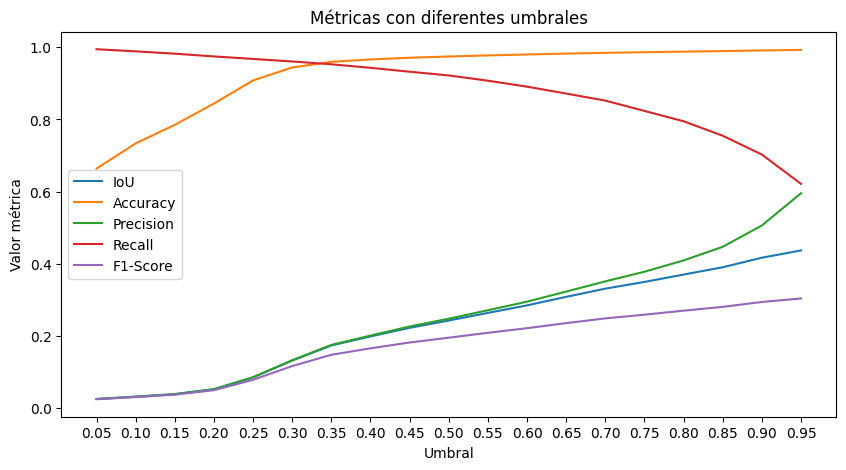

In [23]:
show_threshold_results(aug_results, thresholds=thresholds)

IoU: 0.4372
Accuracy: 0.9929
Precision: 0.5958
Recall: 0.6215
F1 score: 0.3042


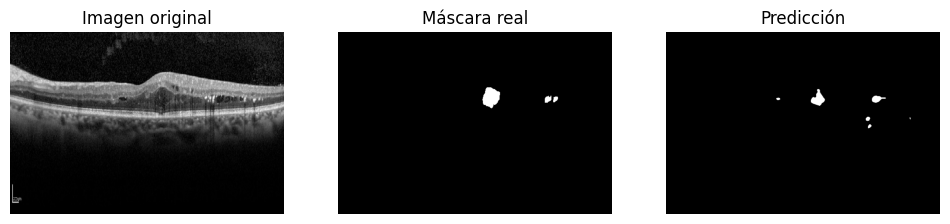

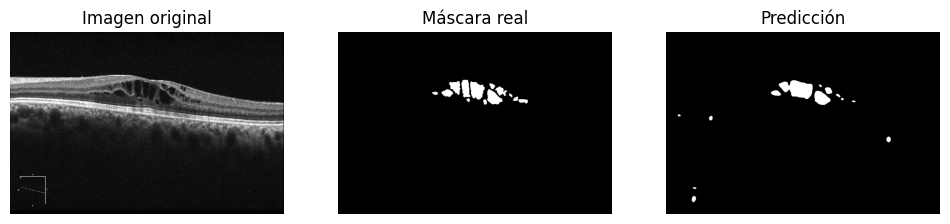

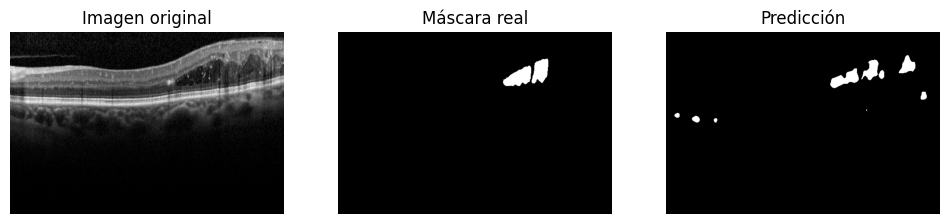

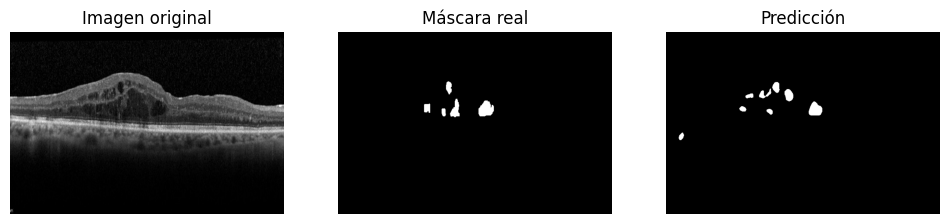

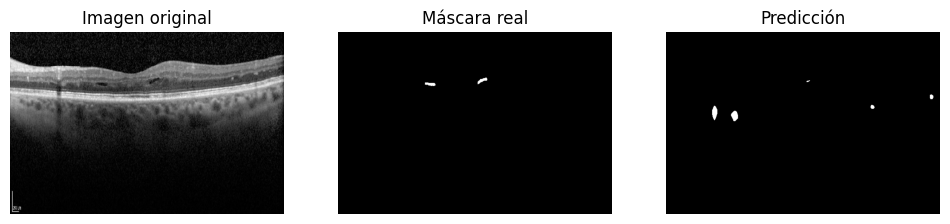

In [24]:
thresh = 0.95

test_model(results=aug_results, model=aug, threshold=thresh, test_loader=test_loader)

## BCE + Dice Loss

In [25]:
# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        targets = targets.view(-1)
        intersection = (probs * targets).sum()
        dice = (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)
        return 1 - dice

# BCE + Dice
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, pos_weight=None):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        dice_loss = self.dice(logits, targets)
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss


### Entrenamiento

In [26]:
bce_dice_model = UNet(input_channels=1, n_class=1)

# Nueva función de pérdida: BCE + Dice
criterion = BCEDiceLoss(bce_weight=0.5, pos_weight=pos_weight)
optimizer = optim.Adam(bce_dice_model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=7)

Epoch [1/90] | Train Loss: 1.0490 | Val Loss: 1.0256 | Time: 9.47
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [2/90] | Train Loss: 1.0465 | Val Loss: 1.0203 | Time: 9.59
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [3/90] | Train Loss: 1.0408 | Val Loss: 1.0077 | Time: 9.54
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [4/90] | Train Loss: 1.0374 | Val Loss: 1.0037 | Time: 9.61
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [5/90] | Train Loss: 1.0324 | Val Loss: 1.0014 | Time: 9.59
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [6/90] | Train Loss: 1.0258 | Val Loss: 0.9893 | Time: 9.81
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [7/90] | Train Loss: 1.0147 | Val Loss: 0.9634 | Time: 9.99
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [8/90] | Train Loss: 0.9912 | Val Loss: 0.9310 | Time: 9.5
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [9/90] | Train Loss: 0.9849 | Val Loss: 0.9106 | Time: 9.68
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [10/90] | Trai

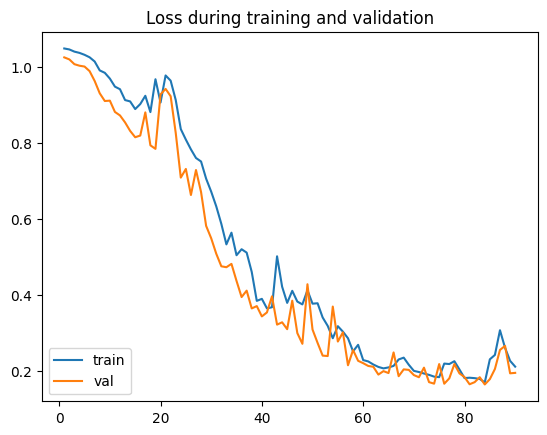

In [27]:
epochs = 90
bce_dice_model_path = "bce_dice_model.pth"

bce_dice_model = train_model(model=bce_dice_model,
                                optimizer=optimizer,
                                scheduler=scheduler,
                                loss_fn=criterion,
                                train_loader=train_loader,
                                val_loader=val_loader,
                                num_epochs=epochs,
                                model_path=bce_dice_model_path
                                )

### Evaluación

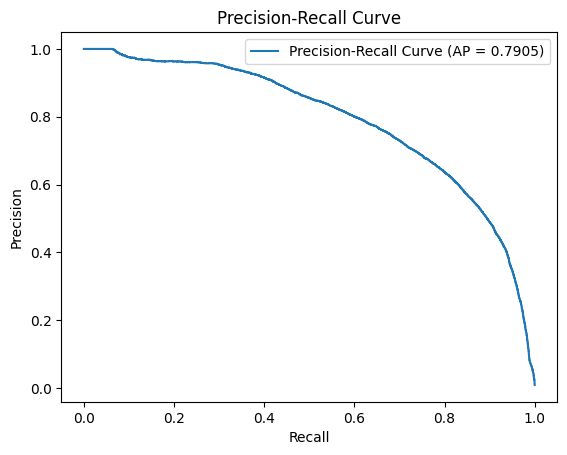

,Threshold,IoU,Accuracy,Precision,Recall,F1-Score
0,0.05,0.4634,0.9907,0.4884,0.9004,0.3167
1,0.10,0.4984,0.9922,0.5375,0.8728,0.3326
2,0.15,0.5165,0.9929,0.5677,0.8513,0.3406
3,0.20,0.5306,0.9934,0.5927,0.8350,0.3466
4,0.25,0.5395,0.9938,0.6111,0.8215,0.3504
5,0.30,0.5466,0.9940,0.6278,0.8088,0.3534
6,0.35,0.5509,0.9942,0.6417,0.7957,0.3552
7,0.40,0.5531,0.9944,0.6523,0.7844,0.3561
8,0.45,0.5560,0.9945,0.6652,0.7720,0.3573
9,0.50,0.5574,0.9946,0.6765,0.7599,0.3579


In [28]:
bce_dice_results = evaluate_thresholds(bce_dice_model, model_path=bce_dice_model_path, thresholds=thresholds, test_loader=test_loader)

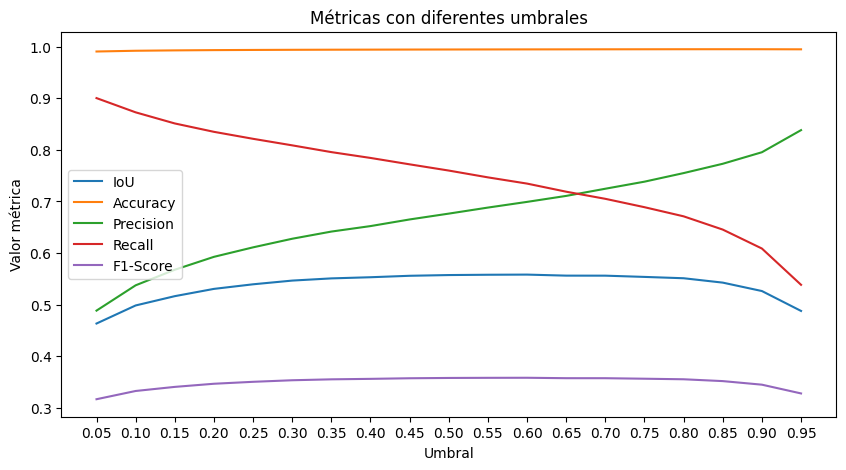

In [29]:
show_threshold_results(bce_dice_results, thresholds=thresholds)

IoU: 0.5563
Accuracy: 0.9949
Precision: 0.7108
Recall: 0.7190
F1 score: 0.3574


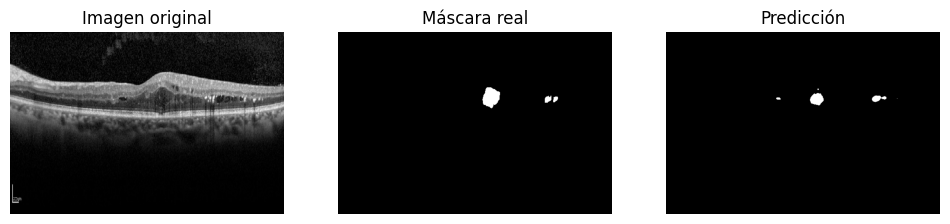

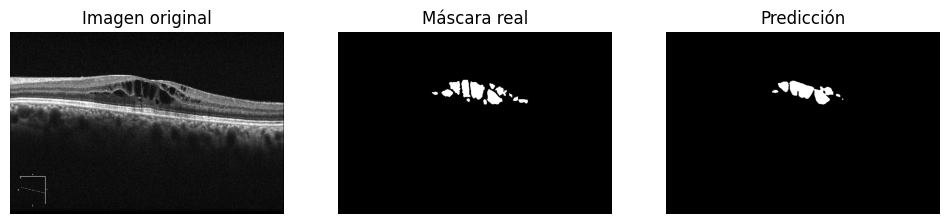

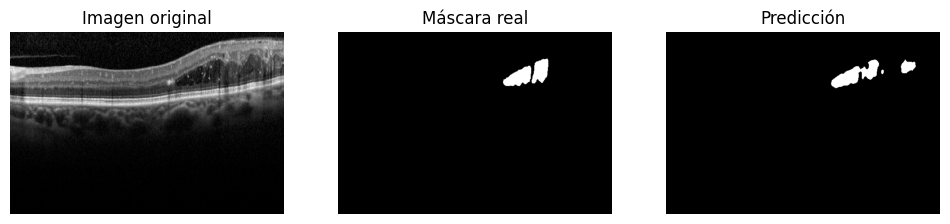

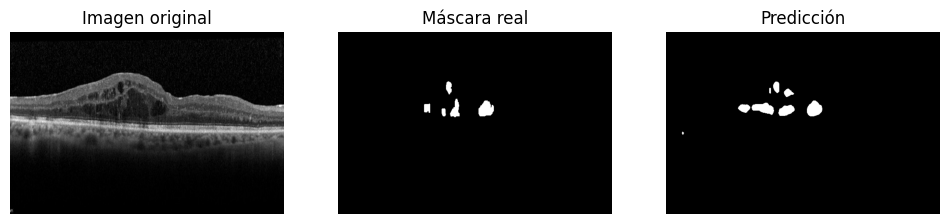

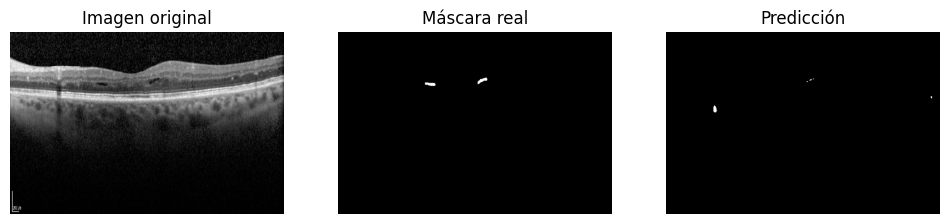

In [34]:
thresh = 0.65

test_model(results=bce_dice_results, model=bce_dice_model, threshold=thresh, test_loader=test_loader)

## IoU Loss

In [35]:
class JaccardLoss(nn.Module):
    def __init__(self):
        super(JaccardLoss, self).__init__()

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        targets = targets.view(-1)
        intersection = (probs * targets).sum()
        union = probs.sum() + targets.sum() - intersection
        jaccard = (intersection) / (union)
        return 1 - jaccard


### Entrenamiento

In [36]:
jaccard_model = UNet(input_channels=1, n_class=1)

criterion = JaccardLoss()
optimizer = optim.Adam(jaccard_model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=7)

Epoch [1/90] | Train Loss: 0.9839 | Val Loss: 0.9855 | Time: 9.37
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [2/90] | Train Loss: 0.9839 | Val Loss: 0.9855 | Time: 9.51
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [3/90] | Train Loss: 0.9839 | Val Loss: 0.9854 | Time: 9.64
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [4/90] | Train Loss: 0.9838 | Val Loss: 0.9853 | Time: 9.71
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [5/90] | Train Loss: 0.9836 | Val Loss: 0.9851 | Time: 10.03
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [6/90] | Train Loss: 0.9832 | Val Loss: 0.9841 | Time: 9.48
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [7/90] | Train Loss: 0.9816 | Val Loss: 0.9809 | Time: 9.46
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [8/90] | Train Loss: 0.9778 | Val Loss: 0.9752 | Time: 9.43
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [9/90] | Train Loss: 0.9729 | Val Loss: 0.9698 | Time: 9.9
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [10/90] | Tra

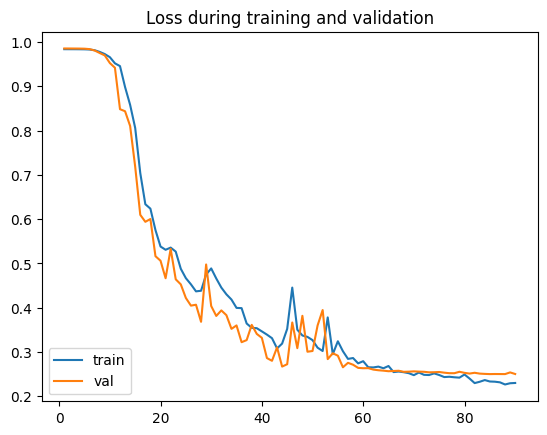

In [37]:
epochs = 90
jaccard_model_path = "iou_model.pth"

jaccard_model = train_model(model=jaccard_model,
                                optimizer=optimizer,
                                scheduler=scheduler,
                                loss_fn=criterion,
                                train_loader=train_loader,
                                val_loader=val_loader,
                                num_epochs=epochs,
                                model_path=jaccard_model_path
                                )

### Evaluación

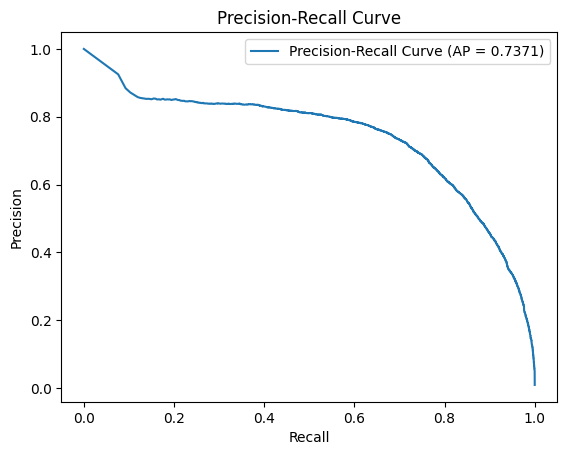

,Threshold,IoU,Accuracy,Precision,Recall,F1-Score
0,0.05,0.5595,0.9948,0.6976,0.7387,0.3588
1,0.10,0.5589,0.9949,0.7109,0.7232,0.3585
2,0.15,0.5606,0.9950,0.7212,0.7157,0.3592
3,0.20,0.5591,0.9950,0.7264,0.7082,0.3586
4,0.25,0.5578,0.9951,0.7308,0.7020,0.3581
5,0.30,0.5571,0.9951,0.7339,0.6980,0.3578
6,0.35,0.5552,0.9951,0.7364,0.6928,0.3570
7,0.40,0.5546,0.9951,0.7398,0.6890,0.3568
8,0.45,0.5544,0.9951,0.7432,0.6858,0.3567
9,0.50,0.5544,0.9951,0.7463,0.6831,0.3566


In [38]:
jaccard_results = evaluate_thresholds(jaccard_model, model_path=jaccard_model_path, thresholds=thresholds, test_loader=test_loader)

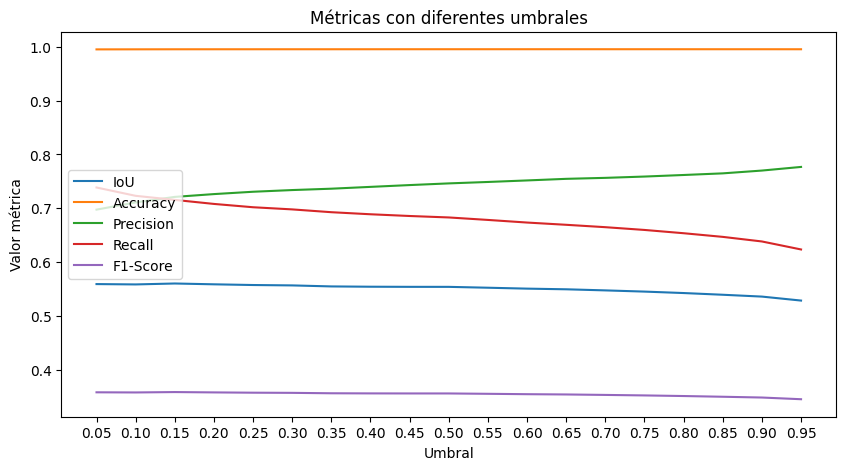

In [39]:
show_threshold_results(jaccard_results, thresholds=thresholds)

IoU: 0.5606
Accuracy: 0.9950
Precision: 0.7212
Recall: 0.7157
F1 score: 0.3592


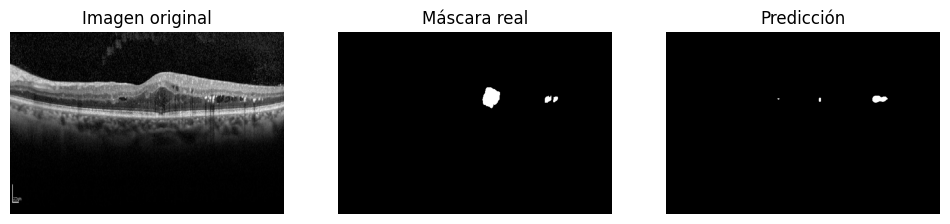

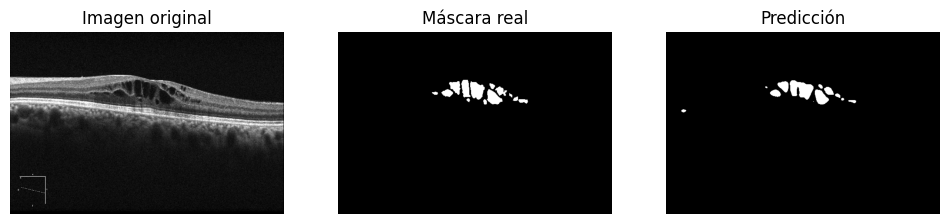

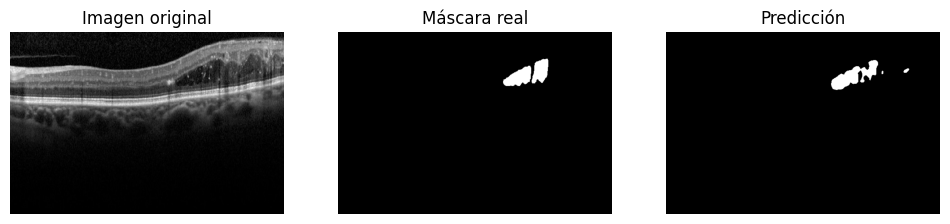

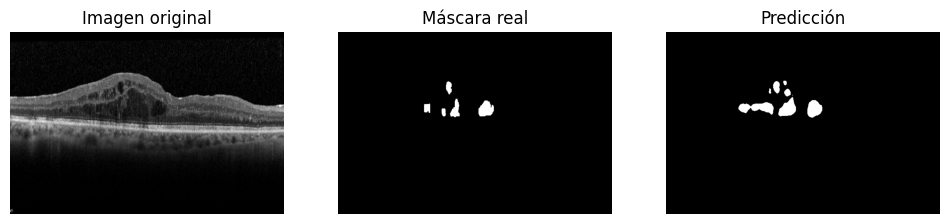

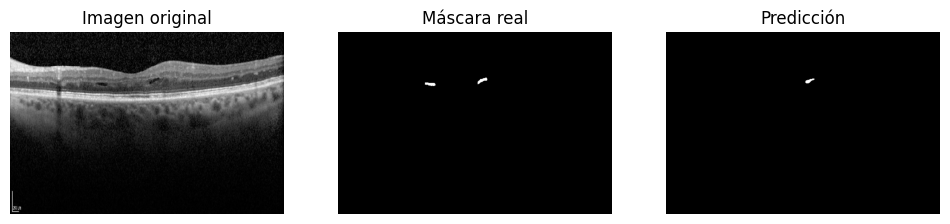

In [44]:
thresh = 0.15

test_model(results=jaccard_results, model=jaccard_model, threshold=thresh, test_loader=test_loader)

## BCE + Hausdorff Loss

In [45]:
from scipy.ndimage import distance_transform_edt

def compute_distance_map(mask):
    # For foreground: distance from background pixels to nearest foreground pixel
    return distance_transform_edt(1 - mask)

class HausdorffLoss(nn.Module):
    def __init__(self):
        super(HausdorffLoss, self).__init__()

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        loss_batch = 0.0
        # Process sample by sample since distance transform is computed in numpy
        for i in range(probs.shape[0]):
            # Squeeze channel dimension and detach to CPU for processing
            pred_map = probs[i, 0].detach().cpu().numpy()
            gt_map = targets[i, 0].detach().cpu().numpy()
            # Make sure ground truth is binary
            gt_bin = (gt_map > 0.5).astype(np.uint8)

            # Compute distance maps:
            # dt_gt: for image background points, the distance to the closest foreground pixel in gt.
            dt_gt = compute_distance_map(gt_bin)
            # For the complement prediction (i.e., estimated background), compute distance transform of gt complement.
            dt_pred = compute_distance_map(1 - gt_bin)

            # Convert distance maps to tensors (same device as logits)
            dt_gt_tensor = torch.from_numpy(dt_gt).to(logits.device).float()
            dt_pred_tensor = torch.from_numpy(dt_pred).to(logits.device).float()

            # Use the probability map without detaching so gradients are propagated.
            pred_tensor = probs[i, 0]

            # Two loss terms:
            # 1. Penalize foreground prediction errors weighted by distance from the gt foreground boundary.
            loss_fg = torch.mean(((pred_tensor) * dt_gt_tensor)**2)
            # 2. Penalize background prediction errors weighted by distance from the gt background boundary.
            loss_bg = torch.mean(((1 - pred_tensor) * dt_pred_tensor)**2)


            loss_batch += loss_fg + loss_bg

        loss_batch /= probs.shape[0]
        return loss_batch

class CombinedLoss(nn.Module):
    def __init__(self, bce_loss, hausdorff_loss, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.bce = bce_loss
        self.hausdorff = hausdorff_loss

    def forward(self, logits, targets):
        loss1 = self.bce(logits, targets)
        loss2 = self.hausdorff(logits, targets)
        return self.alpha * loss1 + (1 - self.alpha) * loss2


### Entrenamiento

In [ ]:
hausdorff_model = UNet(input_channels=1, n_class=1)

bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
hausdorff_loss = HausdorffLoss()
criterion = CombinedLoss(bce_loss, hausdorff_loss, alpha=0.99)
optimizer = optim.Adam(hausdorff_model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=7)

Epoch [1/90] | Train Loss: 86.7633 | Val Loss: 99.4379 | Time: 10.86
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [2/90] | Train Loss: 84.6025 | Val Loss: 94.3013 | Time: 11.74
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [3/90] | Train Loss: 69.2513 | Val Loss: 29.6991 | Time: 11.56
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [4/90] | Train Loss: 11.6305 | Val Loss: 13.3297 | Time: 11.37
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [5/90] | Train Loss: 16.7321 | Val Loss: 11.1782 | Time: 11.48
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [6/90] | Train Loss: 7.6474 | Val Loss: 3.7915 | Time: 11.5
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [7/90] | Train Loss: 4.1618 | Val Loss: 6.1976 | Time: 11.04
Epoch [8/90] | Train Loss: 4.7296 | Val Loss: 3.2952 | Time: 10.85
  ↳ Modelo guardado (el mejor hasta ahora)
Epoch [9/90] | Train Loss: 3.9272 | Val Loss: 3.8115 | Time: 11.47
Epoch [10/90] | Train Loss: 3.8674 | Val Loss: 3.2004 | Time: 10.99
  ↳ Modelo guardado

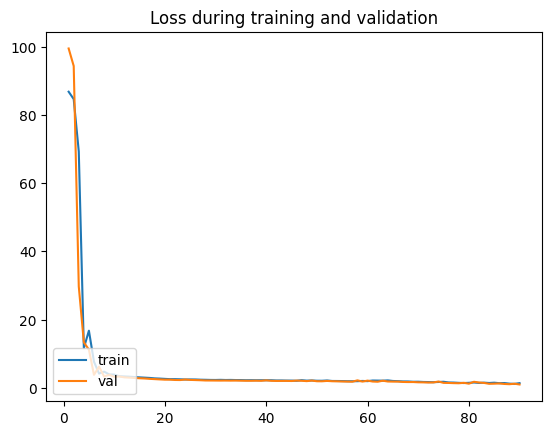

In [ ]:
epochs = 120
hausdorff_model_path = "hausdorff_model.pth"

hausdorff_model = train_model(model=hausdorff_model,
                                optimizer=optimizer,
                                scheduler=scheduler,
                                loss_fn=criterion,
                                train_loader=train_loader,
                                val_loader=val_loader,
                                num_epochs=epochs,
                                model_path=hausdorff_model_path)

### Evaluación

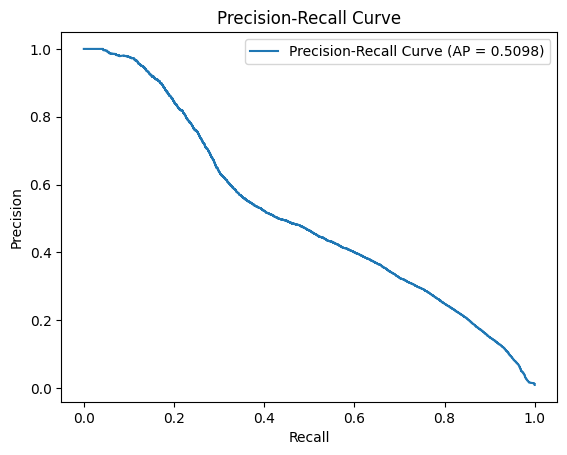

,Threshold,IoU,Accuracy,Precision,Recall,F1-Score
0,0.05,0.1089,0.9320,0.1097,0.9370,0.0982
1,0.10,0.1928,0.9683,0.1994,0.8541,0.1616
2,0.15,0.2580,0.9804,0.2801,0.7660,0.2051
3,0.20,0.2988,0.9860,0.3498,0.6719,0.2301
4,0.25,0.3173,0.9889,0.4121,0.5797,0.2409
5,0.30,0.3115,0.9909,0.4846,0.4657,0.2375
6,0.35,0.2746,0.9919,0.5690,0.3467,0.2154
7,0.40,0.2119,0.9926,0.8075,0.2232,0.1749
8,0.45,0.0000,0.9911,0.0000,0.0000,0.0000
9,0.50,0.0000,0.9911,0.0000,0.0000,0.0000


In [48]:
hausdorff_results = evaluate_thresholds(hausdorff_model, model_path=hausdorff_model_path, thresholds=thresholds, test_loader=test_loader)

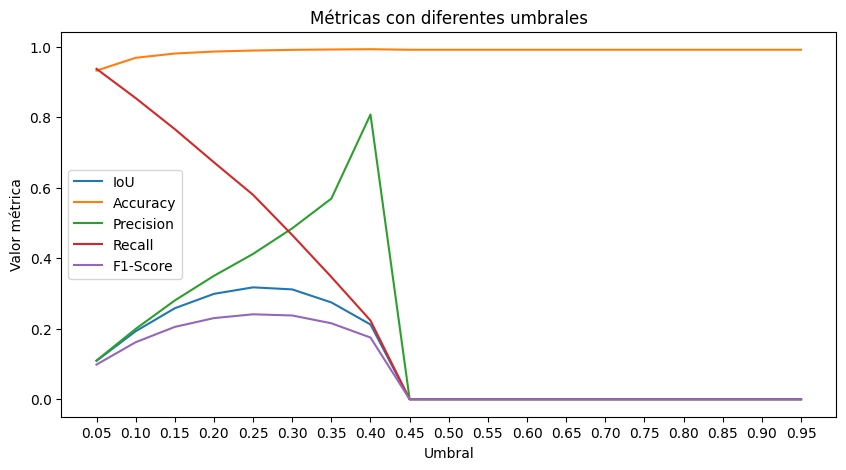

In [49]:
show_threshold_results(hausdorff_results, thresholds=thresholds)

IoU: 0.3173
Accuracy: 0.9889
Precision: 0.4121
Recall: 0.5797
F1 score: 0.2409


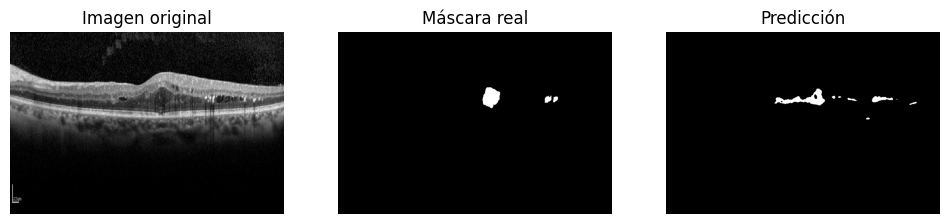

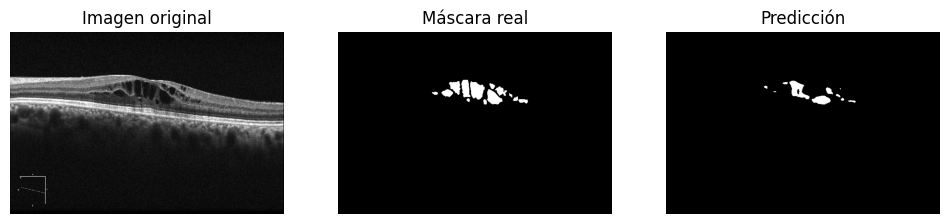

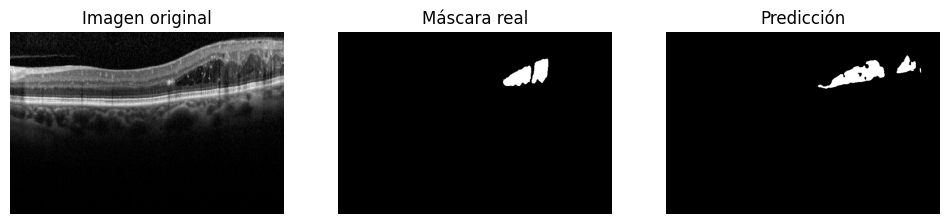

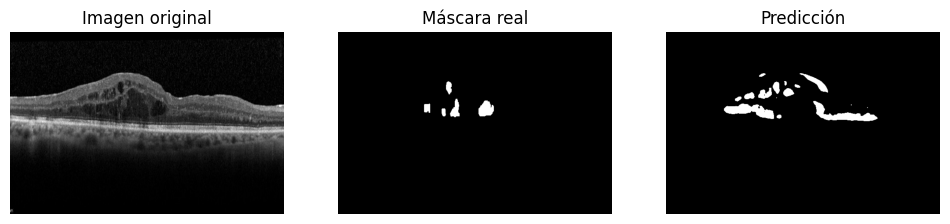

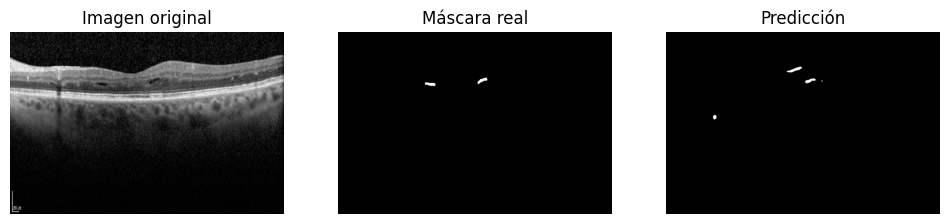

In [51]:
thresh = 0.25

test_model(results=hausdorff_results, model=hausdorff_model, threshold=thresh, test_loader=test_loader)